In [1]:
import os
import cv2
import shutil
import numpy as np
from random import seed, random
import matplotlib.pyplot as plt
import keras
from keras.layers import Flatten,Dense
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from tensorflow.keras.models import load_model

# !pip install livelossplot
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [2]:
train_path = 'dataset/Train/'
#for test
val_path = 'dataset/Test/'
batch_size = 8
image_size = 150
num_classes = 2

In [3]:
train_datagen = ImageDataGenerator(
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        directory=train_path,
                        target_size=(image_size,image_size),
                        batch_size=batch_size,
                        subset='training',
                        class_mode='categorical',
                        color_mode='rgb',
                        shuffle=True)
#validation generator 
validation_generator = train_datagen.flow_from_directory(
                        directory=val_path,
                        target_size=(image_size,image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        color_mode='rgb',
                        shuffle=True) # it stuffle the order of image

Found 70 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


In [4]:
preprocessing_function=keras.applications.resnet50.preprocess_input
# Data augmentation
training_data_generator = ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

In [5]:
#Load the Resnet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
print(base_model.summary())
# Freeze the layers 
for layer in base_model.layers:
    layer.trainable = False

# # Create the model
model = keras.models.Sequential()
# # Add the vgg convolutional base model
model.add(base_model)
 
# # Add new layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [6]:
#we are using resent50 weights so image generator ois also of resnet
# Freeze the layers 
for layer in base_model.layers:
    layer.trainable = False

# # Create the model
model = keras.models.Sequential()
# # Add the vgg convolutional base model
model.add(base_model)
 
# # Add new layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
 
# # Show a summary of the model. Check the number of trainable parameters    
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1026      
Total params: 49,803,650
Trainable params: 26,215,938
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [7]:
# # Compile the model
model.compile(loss='categorical_crossentropy',
          optimizer=SGD(lr=1e-3),
          metrics=['accuracy'])

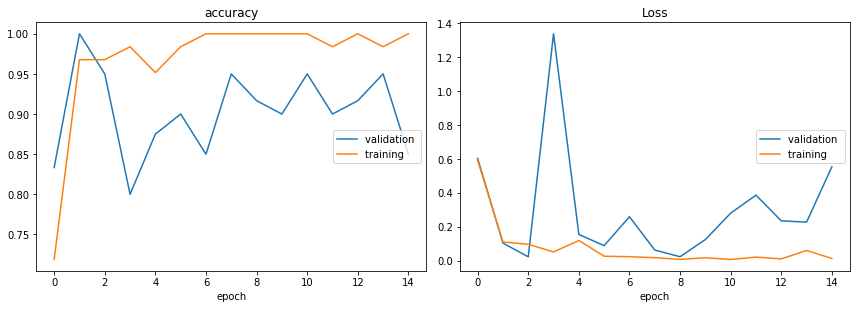

accuracy
	validation       	 (min:    0.800, max:    1.000, cur:    0.850)
	training         	 (min:    0.719, max:    1.000, cur:    1.000)
Loss
	validation       	 (min:    0.022, max:    1.339, cur:    0.554)
	training         	 (min:    0.006, max:    0.592, cur:    0.012)


In [8]:
model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator.filenames) // batch_size,
    epochs=15,
    workers=0,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // batch_size,
    callbacks=[PlotLossesKeras()], 
    verbose=1)

In [9]:
model.save("covid.h5")

In [25]:
def test(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(150,150))
    image.resize(1,150, 150,3)

    model = load_model('covid.h5')
    test_features = model.predict(image)

    classes = ['Covid Detected','Covid Not Detected']

    pred_i=test_features[0].argmax(axis=-1)
    print("Prediction: ", classes[pred_i])
    print("Probabilties :",test_features[0][pred_i])

#     im = image[0]
#     plt.imshow(im)
#     plt.savefig("Output.jpg")
    
    shutil.copy(path, "static/op.jpg")
    
    return classes[pred_i], test_features[0][pred_i]

In [26]:
test("dataset/Test/covid/covid (20).jpg")

Prediction:  Covid Detected
Probabilties : 0.99444926


('Covid Detected', 0.99444926)

In [23]:
test("dataset/Test/covid/covid (36).jpeg")

Prediction:  Covid Detected
Probabilties : 0.9456991


('Covid Detected', 0.9456991)

In [24]:
test("dataset/Test/normal/IM-0243-0001.jpeg")

Prediction:  Covid Not Detected
Probabilties : 0.99977857


('Covid Not Detected', 0.99977857)

In [28]:
from flask import Flask, request, make_response, jsonify, render_template
import requests
from tensorflow.keras.models import load_model

app = Flask(__name__, template_folder='templates')

@app.route('/', methods=['GET','POST'])
def home():
    pred = "Enter File for Diagnosis"
    prob = 0
    f_path=request.args.get("f_path")
    
    if f_path:        
        pred, prob = test(f_path)
        
    return render_template('index.html', prediction=pred, probability = np.round(prob*100,2))
    
if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [07/Jul/2020 16:14:29] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:14:29] "GET /assets/img/logo/logo.png HTTP/1.1" 404 -
127.0.0.1 - - [07/Jul/2020 16:14:30] "GET /site.webmanifest HTTP/1.1" 404 -
127.0.0.1 - - [07/Jul/2020 16:15:03] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:15:04] "GET /assets/img/logo/logo.png HTTP/1.1" 404 -
127.0.0.1 - - [07/Jul/2020 16:15:04] "GET /site.webmanifest HTTP/1.1" 404 -
[2020-07-07 16:16:10,269] ERROR in app: Exception on / [GET]
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\flask\app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\ProgramData\Anaconda3\lib\site-packages\flask\app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\ProgramData\Anaconda3\lib\site-packages\flask\app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_va

127.0.0.1 - - [07/Jul/2020 16:16:25] "GET /?f_path=dataset%2FTest%2Fnormal%2FIM-0243-0001.jpeg HTTP/1.1" 200 -


Prediction:  Covid Not Detected
Probabilties : 0.99977857


127.0.0.1 - - [07/Jul/2020 16:16:25] "GET /assets/img/logo/logo.png HTTP/1.1" 404 -
127.0.0.1 - - [07/Jul/2020 16:16:26] "GET /site.webmanifest HTTP/1.1" 404 -


127.0.0.1 - - [07/Jul/2020 16:16:54] "GET /?f_path=dataset%2FTest%2Fnormal%2FIM-0243-0001.jpeg HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:16:54] "GET /static/assets/css/bootstrap.min.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:16:54] "GET /static/assets/css/slicknav.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:16:54] "GET /static/assets/css/animate.min.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:16:54] "GET /static/assets/css/flaticon.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:16:54] "GET /static/assets/css/owl.carousel.min.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:16:54] "GET /static/assets/css/magnific-popup.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:16:54] "GET /static/assets/css/themify-icons.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:16:54] "GET /static/assets/css/fontawesome-all.min.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:16:54] "GET /static/assets/css/slick.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:16:54] "GET /s

Prediction:  Covid Not Detected
Probabilties : 0.99977857


127.0.0.1 - - [07/Jul/2020 16:16:54] "GET /static/assets/js/vendor/modernizr-3.5.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:16:54] "GET /static/assets/js/vendor/jquery-1.12.4.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:16:54] "GET /static/assets/js/popper.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:16:54] "GET /static/assets/js/bootstrap.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:16:54] "GET /static/assets/js/jquery.slicknav.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:16:54] "GET /static/assets/js/owl.carousel.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:16:54] "GET /static/assets/js/slick.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:16:54] "GET /static/assets/js/wow.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:16:54] "GET /static/assets/js/animated.headline.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:16:54] "GET /static/assets/js/jquery.scrollUp.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:16:54] "GE

127.0.0.1 - - [07/Jul/2020 16:18:06] "GET /?f_path=dataset%2FTest%2Fcovid%2Fcovid+%2820%29.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:18:06] "GET /assets/img/logo/logo.png HTTP/1.1" 404 -


Prediction:  Covid Detected
Probabilties : 0.99444926


127.0.0.1 - - [07/Jul/2020 16:18:06] "GET /site.webmanifest HTTP/1.1" 404 -


127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /?f_path=dataset%2FTest%2Fcovid%2Fcovid+%2820%29.jpg HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /static/assets/css/bootstrap.min.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /static/assets/css/owl.carousel.min.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /static/assets/css/flaticon.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /static/assets/css/slicknav.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /static/assets/css/animate.min.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /static/assets/css/magnific-popup.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /static/assets/css/fontawesome-all.min.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /static/assets/css/themify-icons.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /static/assets/css/slick.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /s

Prediction:  Covid Detected
Probabilties : 0.99444926


127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /static/assets/js/vendor/jquery-1.12.4.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /static/assets/js/popper.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /static/assets/js/bootstrap.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /static/assets/js/jquery.slicknav.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /static/assets/js/owl.carousel.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /static/assets/js/slick.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /static/assets/js/wow.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /static/assets/js/animated.headline.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /static/assets/js/jquery.magnific-popup.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /static/assets/js/jquery.scrollUp.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Jul/2020 16:18:21] "GET /st